In [49]:
# Run this cell if you are using Google Colab
#%%capture
! pip install arviz==0.11.00
! pip install pymc3==3.11.1
! pip install seaborn==0.11.1

In [2]:
conda install mkl-service

failed

Note: you may need to restart the kernel to use updated packages.


In [50]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from pymc3 import math
from scipy import stats
import theano
from math import pi, sqrt, exp

sns.set_context('talk')

     |████████████████████████████████| 155 kB 4.7 MB/s eta 0:00:01


# Portfolio 1

In the following exercises, we are going to analyse response time data  from a recent paper [(Legrand et al., 2021)](https://www.biorxiv.org/content/10.1101/2021.02.18.431871v1) using PyMC3.

In [8]:
# Load data frame
DF = pd.read_csv('https://github.com/embodied-computation-group/CardioceptionPaper/raw/main/data/Del2_merged.txt')

## Exercise 1 - Preprocessing

In [8]:
DF.head()

,TrialType,Condition,Modality,StairCond,Decision,DecisionRT,Confidence,ConfidenceRT,Alpha,listenBPM,...,EstimatedThreshold,EstimatedSlope,StartListening,StartDecision,ResponseMade,RatingStart,RatingEnds,endTrigger,HeartRateOutlier,Subject
0,psiCatchTrial,Less,Intero,psiCatchTrial,Less,1.933293,99.0,0.512461,-30.0,66.5,...,NaN,NaN,1.603353e+09,1.603353e+09,1.603353e+09,1.603353e+09,1.603353e+09,1.603353e+09,False,sub_0019
1,psi,Less,Extero,psi,Less,2.216429,59.0,1.632995,-0.5,78.0,...,22.80555,12.549457,1.603353e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,False,sub_0019
2,psiCatchTrial,More,Intero,psiCatchTrial,Less,3.099441,25.0,0.729331,10.0,67.0,...,NaN,NaN,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,False,sub_0019
3,psiCatchTrial,Less,Extero,psiCatchTrial,Less,1.449154,100.0,0.511938,-30.0,82.0,...,NaN,NaN,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,False,sub_0019
4,psi,Less,Intero,psi,Less,2.099316,41.0,1.243842,-0.5,65.5,...,22.80555,12.549457,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,False,sub_0019


This data frame contains behavioral results from a lot of participants, doing a lot of different tasks. The data of interest for us are stored in the `ConfidenceRT` column. This is the time the participant takes to rate a confidence rating scale. Before we go to the analysis part, we should filter this data frame a bit.

* Here we only want to analyze the modality labeled as `Intero`, and drop the other one. 
* We only want to keep the `Subject` and the `ConfidenceRT` columns. 
* Sometimes, no responses were made by the participant, so the column potentially contains NaN values that should be removed. 
* Because we are just testing new models here, we only want to analyze a sub-sample of the data to save time and memory, so we are going to analyze subjects whose ID ends with a `7` and drop the rest of the participants.

You should end up with a data frame containing 2 columns, 1158 rows, and the response time data from 20 participants in total. If you have difficulties doing this filtering process, you can just skip this question and use the entire `ConfidenceRT` column for the next questions.

In [9]:
df = DF[DF["Modality"] == "Intero"]
df.head()

,TrialType,Condition,Modality,StairCond,Decision,DecisionRT,Confidence,ConfidenceRT,Alpha,listenBPM,...,EstimatedThreshold,EstimatedSlope,StartListening,StartDecision,ResponseMade,RatingStart,RatingEnds,endTrigger,HeartRateOutlier,Subject
0,psiCatchTrial,Less,Intero,psiCatchTrial,Less,1.933293,99.0,0.512461,-30.0,66.5,...,NaN,NaN,1.603353e+09,1.603353e+09,1.603353e+09,1.603353e+09,1.603353e+09,1.603353e+09,False,sub_0019
2,psiCatchTrial,More,Intero,psiCatchTrial,Less,3.099441,25.0,0.729331,10.0,67.0,...,NaN,NaN,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,False,sub_0019
4,psi,Less,Intero,psi,Less,2.099316,41.0,1.243842,-0.5,65.5,...,22.805550,12.549457,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,False,sub_0019
5,psi,More,Intero,psi,More,1.283556,68.0,1.058548,22.5,65.5,...,10.001882,12.884902,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,False,sub_0019
7,psi,More,Intero,psi,Less,3.166090,4.0,1.254876,10.5,67.5,...,18.938407,12.726249,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,False,sub_0019


In [10]:
cols = ["Subject", "ConfidenceRT"]
temp = df[cols]
temp.head()


,Subject,ConfidenceRT
0,sub_0019,0.512461
2,sub_0019,0.729331
4,sub_0019,1.243842
5,sub_0019,1.058548
7,sub_0019,1.254876


In [12]:

mask = temp[['Subject']].apply(
    lambda x: x.str.contains(
        'sub_...7',
        regex=True
    )
).any(axis=1)
print (temp[mask])

filtered = temp[mask]

        Subject  ConfidenceRT
720    sub_0027      1.449933
721    sub_0027      1.339900
722    sub_0027      1.109791
723    sub_0027      1.718936
724    sub_0027      1.429110
...         ...           ...
21951  sub_0247      0.510296
21952  sub_0247      1.286835
21955  sub_0247      0.945952
21956  sub_0247      0.512421
21957  sub_0247      0.827551

[1200 rows x 2 columns]


In [13]:
filtered.isna()
filtered["Subject"].unique()

array(['sub_0027', 'sub_0037', 'sub_0047', 'sub_0057', 'sub_0067',
       'sub_0087', 'sub_0097', 'sub_0107', 'sub_0117', 'sub_0127',
       'sub_0137', 'sub_0147', 'sub_0157', 'sub_0177', 'sub_0187',
       'sub_0197', 'sub_0207', 'sub_0217', 'sub_0237', 'sub_0247'],
      dtype=object)

## Exercise 2 - Gaussian model
There are many ways to describe response time distribution. The most intuitive and simple model would be to use a normal distribution and use the mean and precision of this distribution as parameters of interest for each subject.

We know from the experimental design that the response time cannot be less than 0 seconds or more than 5 seconds. Our first guess will be to use a normal distribution with a mean $\mu$ and a standard deviation $\sigma$. The mean might come from another normal distribution centered at 2.5. We don't want it to be too informative so the standard deviation will be set at 10. The standard deviation might come from a HalfCauchy distribution with a beta parameter set to `2`.

* Use PyMC3 to fit this model to the responses from the first participant only (`sub_0027`) and create one plot using Arviz to synthesize your results.
* Why did you choose this plot?

# Because it's very useful to grasp the characteristics of the outcome variable. 

* Describe what is represented in your plot

# It is a diagnositc plot, which shows the marginalized distribution for each parameter on the left side, and the trace plot (parameter value as a function of step number) on the right side. On the left, we can see 4 different lines representing four different chains the job was run on. If these would look very different, it would signal that there was some error in the modeling process.

* What information should we check if we want to make sure that the MCMC chain from this model can be trusted?

# We can check that by printing the summary of the trace and looking at the r_hat (the Gelman Rubin statistic) values. If they are around 1, it means that convergence for marginal parameter distributions was successful. Additionally, the n_eff describes the effective number of samples after autocorrelations in the chains have been accounted for.

In [14]:
subj = filtered[filtered["Subject"] == "sub_0027"]
subj = subj["ConfidenceRT"]
subj.head()

720    1.449933
721    1.339900
722    1.109791
723    1.718936
724    1.429110
Name: ConfidenceRT, dtype: float64

In [15]:
subj.to_numpy()
subj = subj.dropna()

In [16]:

with pm.Model() as model1: 
    mu = pm.Normal("mu", 2.5, 10)
    sigma = pm.HalfCauchy('sigma', beta=2)
    y = pm.Normal("y", mu, sigma, observed = subj)
    trace1 = pm.sample(2000, tune = 2000)

/opt/conda/lib/python3.7/site-packages/pymc3/sampling.py:469: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


In [94]:
! pip install bokeh

In [95]:
from bokeh.io import output_notebook
output_notebook()

az.plot_trace(trace1, backend="bokeh")

Loading BokehJS ...

/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[Figure(id='2962', ...), Figure(id='2998', ...)],
       [Figure(id='3034', ...), Figure(id='3070', ...)]], dtype=object)

In [18]:
az.summary(trace1)

/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,1.305,0.077,1.158,1.446,0.001,0.001,6814.0,6800.0,6831.0,5621.0,1.0
sigma,0.589,0.056,0.488,0.692,0.001,0.001,6357.0,6157.0,6581.0,5469.0,1.0


## Exercise 3 - Precision

You want to compare your results with another model from the literature that describes the normal distribution using precision ($\lambda$), and not the standard deviation ($\sigma$). We know that: $$\sigma = \frac{1}{\sqrt{\lambda}}$$

* Use `az. summary` to extract the $\sigma$ value from the previous model, and convert it into a precision ($\lambda$) value.

# The precision value is 2.8923133879402103

In [19]:
az.summary(trace1)

/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,1.305,0.077,1.158,1.446,0.001,0.001,6814.0,6800.0,6831.0,5621.0,1.0
sigma,0.589,0.056,0.488,0.692,0.001,0.001,6357.0,6157.0,6581.0,5469.0,1.0


In [21]:
(1/0.588)**2  # this is the precision value

2.8923133879402103

## Exercise 4 - posterior predictive checks

It turns out that this gaussian model is a terrible one for many reasons. We can explore this a bit more by checking the posterior predictive.

* Extract the posterior predictive for this model using the default parameters from PyMC3.
* Plot posterior predictive checks using built-in Arviz function.
* What does this plot tells us? 
This tells us that the model is not a right fit for the data.
* What are the 2 main disadvantages here for response time data?
# 1) A normal distribution doesn't seem to be the right distriibution for response time, as it is not normally distributed around a value. 2) It also shows that the model is very unsure. This can be seen from the big area all the posterior predictions take up (they are dispersed from the distribution of the observed data).

/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd820774690>,
      dtype=object)

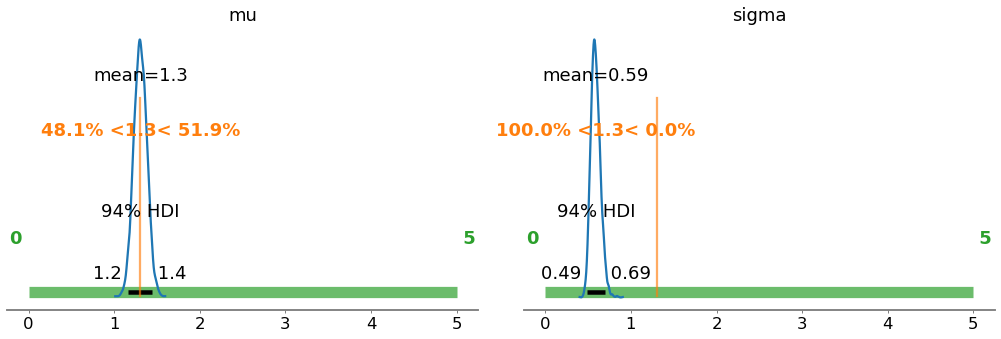

In [22]:
az.plot_posterior(trace1, rope=[1, 5], ref_val=1.3)     #the reasonable interval we expect an answer to be is between 0 and 5 ms, with a mean of 1.3 s

In [75]:
with model1:
    ppc = pm.sample_posterior_predictive(
        trace1, var_names=["y"], random_seed=42
    )

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


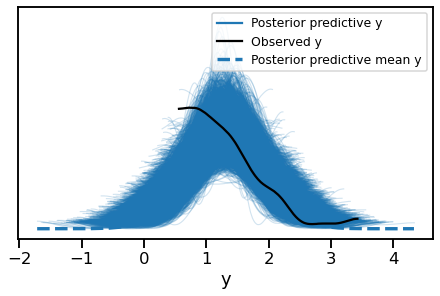

In [76]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model1))

## Exercise 5 - A better model

The normal distribution is indeed a poor fit for response time data. Other sources suggest that the Gamma distribution or the shifted Wald distribution might do a better job (see [this paper](https://www.frontiersin.org/articles/10.3389/fpsyg.2019.00102/full)). You can find all these distributions already implemented in PyMC3.

Using the same data from subject 27, fit, plot, and summarize the following models separately.

* The gamma model

$$ y \sim \mathcal{Gamma}(alpha=\alpha, beta=\beta)$$
$$ \alpha \sim \mathcal{Uniform}(0, 10)$$
$$ \beta \sim  \mathcal{Uniform}(0, 10)$$



/opt/conda/lib/python3.7/site-packages/pymc3/sampling.py:469: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.6964171663382651, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5429392637838453, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the

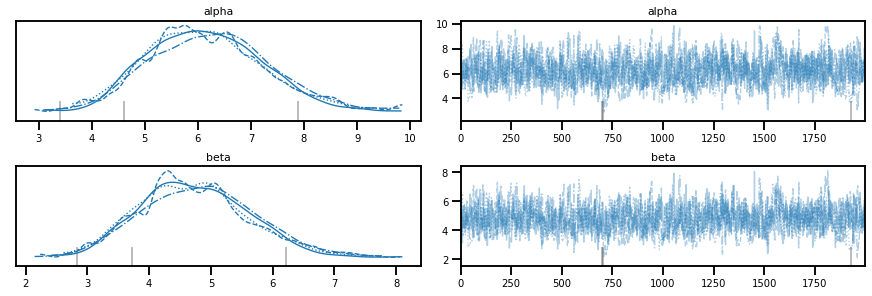

In [25]:
data = subj
with pm.Model() as gamma:
  alpha = pm.Uniform("alpha", lower=0, upper=10)
  beta = pm.Uniform("beta", lower=0, upper=10)
  y = pm.Gamma("y", alpha = alpha, beta = beta, observed = data)
  trace_gamma = pm.sample(2000, tune = 2000)

az.plot_trace(trace_gamma)
gamma_summary = az.summary(trace_gamma)



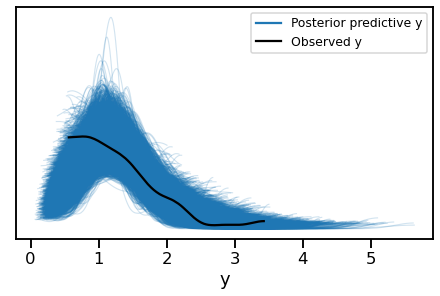

In [26]:
gamma_postpred = pm.sample_posterior_predictive(trace_gamma, model = gamma)
gppc_data = az.from_pymc3(
    trace = trace_gamma, posterior_predictive= gamma_postpred, model = gamma)
az.plot_ppc(gppc_data, mean = False)

* The Wald model

$$ y \sim \mathcal{Wald}(\mu, \lambda)$$
$$ \mu \sim \mathcal{Uniform}(0, 5)$$
$$ \lambda \sim  \mathcal{Uniform}(0, 20)$$

/opt/conda/lib/python3.7/site-packages/pymc3/sampling.py:469: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam, mu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.
/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


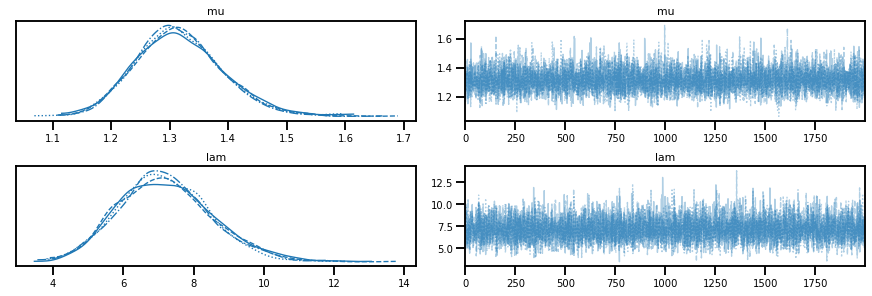

In [27]:
data = subj
with pm.Model() as waldo:
  mu = pm.Uniform("mu", lower=0, upper=5)
  lam = pm.Uniform("lam", lower=0, upper=20)
  y = pm.Wald("y", mu=mu, lam = lam, observed = data)
  waldo_trace = pm.sample(2000, tune = 2000)

az.plot_trace(waldo_trace)
waldo_summary = az.summary(waldo_trace)


In [140]:
az.summary(waldo_trace)

/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,1.316,0.074,1.180,1.455,0.001,0.001,6337.0,6247.0,6491.0,5210.0,1.0
lam,7.190,1.309,4.762,9.640,0.017,0.012,6119.0,5820.0,6256.0,4620.0,1.0


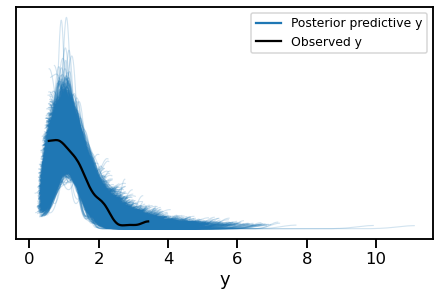

In [28]:
waldo_postpred = pm.sample_posterior_predictive(waldo_trace, model = waldo)
wppc_data = az.from_pymc3(
    trace = waldo_trace, posterior_predictive= waldo_postpred, model = waldo)
az.plot_ppc(wppc_data, mean = False)

## Exercise 6 - Plotting model results

Using the parameters estimates from the previous models, Matplotlib, Seaborn, and the `scipy.stats`module, try to reproduce the following plot
![title](https://github.com/LegrandNico/CognitiveModeling/raw/master/notebooks/data/wald_gamma.png)
:

**Hint**: You can use the gamma function from Scipy to estimate the probability density function, but you will have to create your own Wald function to make it work with the parameters `mu` and `lam` estimated by PyMC3 (see the formula [here](https://en.wikipedia.org/wiki/Inverse_Gaussian_distribution)).

In [33]:
def waldo(xi, wmu, wlam):
  term1 = sqrt(wlam/(pi*(xi**3)*2))
  term2 = -(wlam*(xi-wmu)**2)/(2*(wmu**2)*xi)
  return term1*exp(term2)

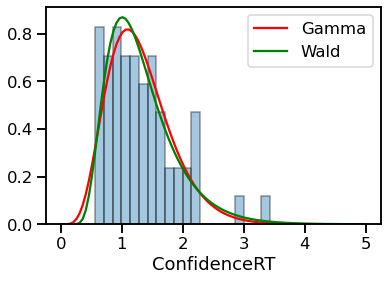

In [89]:
x = np.linspace(0.001,5, 100)

gamma_alpha = gamma_summary['mean']['alpha']
gamma_beta = gamma_summary['mean']['beta']
gamma_pdf = stats.gamma.pdf(x, a = gamma_alpha, scale = 1/gamma_beta)

waldo_mu = waldo_summary['mean']['mu']
waldo_lam = waldo_summary['mean']['lam']
waldo_pdf = np.array([waldo(xi, waldo_mu, waldo_lam) for xi in x])

sns.distplot(data, bins = 20, kde = False, norm_hist = True, hist_kws = {'edgecolor':'black'})

sns.lineplot(x = x, y = gamma_pdf, color = "red", legend = "full", label = "Gamma")
sns.lineplot(x = x, y = waldo_pdf, color = "green", legend = "full", label = "Wald")

## Exercise 6 - Model comparison

Compare the previous models (normal distribution, Gamma, Wald). Which one should we choose? What are the metrics/indexes you use to make your decision?
# It seems like the Wald's WAIC is the closest to 0, so that is the best model to fit the data.

/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:147: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  "The default method used to estimate the weights for each model,"
/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:1468: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarni

          rank       waic    p_waic    d_waic    weight        se       dse  \
wald         0 -43.683393  1.757076  0.000000  0.818638  8.376207  0.000000   
gamma        1 -45.588040  2.118578  1.904647  0.178946  6.818526  1.269497   
gaussian     2 -53.338110  2.943123  9.654716  0.002417  6.115235  3.894723   

          warning waic_scale  
wald        False        log  
gamma        True        log  
gaussian     True        log  


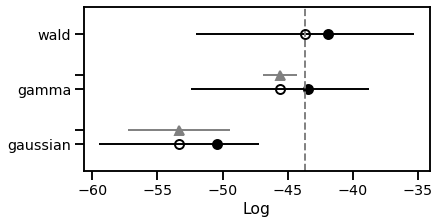

In [100]:
comp = az.compare({'gaussian':trace1, 'gamma':trace_gamma, 'wald':waldo_trace}, method='BB-pseudo-BMA', ic='waic')
print(comp)
az.plot_compare(comp)


## Exercise 7 - Decision

Imagine the following (completely fictitious) situation: Previous researches have shown that the $\mu$ parameter estimated from the Wald distribution is associated with the anxiety level of the participant. The lower this parameter is, the faster the participant is at confidence rating, and the greater the anxiety level is. If $\mu$ is below 1.2, the anxiety level is considered clinically relevant and the participant should be oriented to a specialist.

You want to make a decision concerning subject 27, and you want to make it probabilistically (i.e. you want to take the decision, but also estimate how sure you are about this decision).

* Given your estimation of $\mu$ from the previous model, do you consider this score to be clinically relevant here?
* What is the probability that $\mu$ is acless thanyfor below 1this partiipant?i
Sinxc

# The probabiliy of mu being under 1.2 is low, around 3-4%. It seems to be not that relevant for th cipart.cipant?

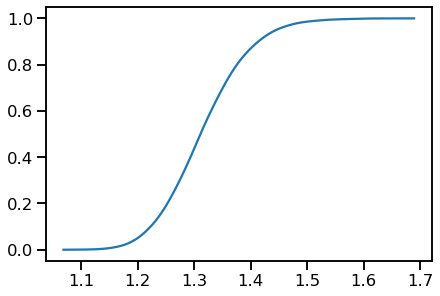

In [105]:
cumulative_dist_func = az.plot_dist(waldo_trace['mu'], cumulative= True) #this plot shows what the probability is for mu being a given x value, or lower

In [142]:
prob_mu_x = [ dat for dat in cumulative_dist_func.lines[0].get_xydata() if dat[0] > 1.19 and dat[0] < 1.21 ][0][1]
print(prob_mu_x)



0.03567950929601999


## Exercise 8 - Hierarchical model

Using the entire dataset this time (20 subjects), we are going to fit a hierarchical Wald model. Instead of fixing the prior of the parameters of the Wald function, we want to sample them from hyperpriors (i.e each participant will have its own $\mu$ and $\lambda$ parameters coming from a unique normal distributionm and we want to estimate the mean and standard deviation of these distributions). The hierarchical model for $i = 20$ participants is defined by:

$$ y_{i} \sim \mathcal{Wald}(\mu_{i}, \lambda_{i})$$
$$ \mu_{i} \sim \mathcal{N}(\mu_{\mu}, \sigma_{\mu})$$
$$ \lambda_{i} \sim  \mathcal{N}(\mu_{\lambda}, \sigma_{\lambda})$$

$$\mu_{\mu} \sim \mathcal{Uniform}(0, 100)$$
$$\mu_{\lambda} \sim \mathcal{Uniform}(0, 100)$$

$$\sigma_{\mu} \sim \mathcal{HalfCauchy}(10)$$
$$\sigma_{\lambda} \sim \mathcal{HalfCauchy}(10)$$


In [135]:
filtered = filtered['ConfidenceRT'].dropna()

df = DF[(DF["Modality"] == "Intero") &  DF["Subject"].str.endswith("7") & DF["ConfidenceRT"].notna()]
df = df[["Subject", "ConfidenceRT"]]


In [137]:
idi = pd.Categorical(df['Subject']).codes
reaction_times = df["ConfidenceRT"].values
groups = len(np.unique(idi))

with pm.Model() as bigboy:
    mu_mu = pm.Uniform('mu_mu', lower = 0, upper = 100)
    mu_lambda = pm.Uniform('mu_lambda', lower = 0, upper = 100)
    sig_mu = pm.HalfCauchy('sig_mu', beta = 10)
    sig_lambda = pm.HalfCauchy('sig_lambda', beta = 10)

    mui = pm.Normal('mui', mu = mu_mu, sigma = sig_mu, shape = groups)
    lambi = pm.Normal('lambi', mu = mu_lambda, sigma = sig_lambda, shape = groups)
    
    hwald = pm.Wald('hwald', mu = mui[idi], lam = lambi[idi], observed = reaction_times)
    hwald_trace = pm.sample(2000, tune = 2000)



/opt/conda/lib/python3.7/site-packages/pymc3/sampling.py:469: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambi, mui, sig_lambda, sig_mu, mu_lambda, mu_mu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 35 seconds.


/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd77e3e51d0>,
      dtype=object)

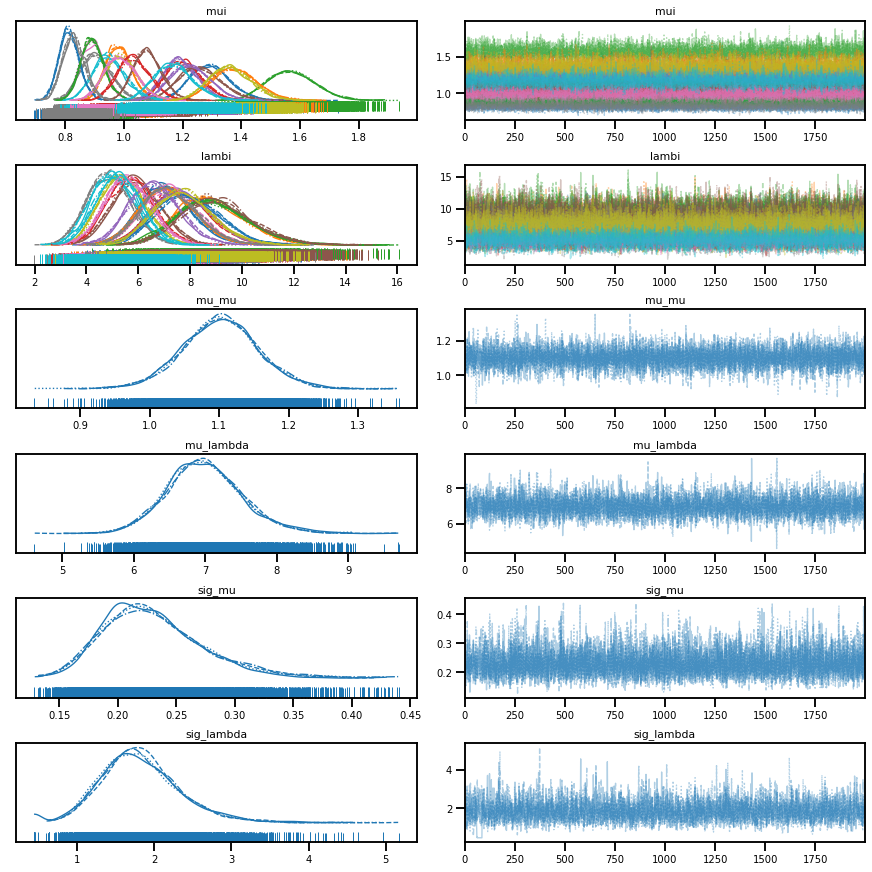

In [138]:
az.plot_trace(hwald_trace, rug=True)